Install library for ARIMA

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.6 MB/s 
     |████████████████████████████████| 9.8 MB 32.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


Imports:

In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

**1. Load the data:**

In [ ]:
drive.mount("drive")
#water_db = pd.read_csv("drive/My Drive/AutomaticAI/Datasets/water_avg_weekly_processed.csv")
water_db = pd.read_csv("drive/My Drive/Colab Notebooks/datasets/water/water_avg_weekly_processed.csv")
dataset = water_db.T
dataset.sample

Mounted at drive


<bound method NDFrame.sample of                      0          1         2          3         4         5    \
0.130434783    20.578947   1.642857  1.920000   1.698113  0.076190  0.297030   
0.133333333     2.631579   2.612903  1.078431  23.473684  0.000000  0.237624   
0               1.333333   1.892473  0.470588   2.508772  0.116505  0.203883   
0.1            15.016949   2.225806  0.401961   1.561404  0.038835  0.153846   
0.2            13.909091   3.610526  0.362745   0.947368  0.000000  0.259615   
...                  ...        ...       ...        ...       ...       ...   
0.119047619.1  31.104478  10.391753  4.669903   5.575000  3.644231  0.654206   
0.018518519    52.880597  11.956044  5.933962   9.976190  0.980769  0.317757   
0.53           20.803030  14.816327  3.133333  24.981481  0.368932  0.196262   
0.092592593.1  14.227273   5.367347  4.180952   6.963636  0.212121  0.323529   
0.54           24.366667   1.346939  3.634615   3.727273  0.067308  0.207921   

       

**2. Preprocessing** (split into standard weeks):

In [ ]:
week_column = range(1, len(dataset) + 1)
dataset.insert(loc = 0, column = 'Week', value = week_column)
dataset = dataset.set_index('Week')
dataset

,0,1,2,3,4,5,6,7,8,9,...,811,812,813,814,815,816,817,818,819,820
Week,,,,,,,,,,,,,,,,,,,,,
1,20.578947,1.642857,1.920000,1.698113,0.076190,0.297030,4.144330,2.204545,0.490566,3.352381,...,1.773810,2.586957,3.178571,0.560000,0.580645,6.313725,1.309091,0.612245,8.824561,21.535714
2,2.631579,2.612903,1.078431,23.473684,0.000000,0.237624,2.690722,1.477273,0.226415,4.126214,...,1.674699,0.266667,1.290909,0.000000,0.064516,6.411765,0.472727,0.102041,0.929825,3.933333
3,1.333333,1.892473,0.470588,2.508772,0.116505,0.203883,3.402062,2.477273,0.047619,2.009615,...,0.180723,0.088889,0.727273,0.020000,0.000000,7.063830,0.236364,0.326531,0.403509,0.466667
4,15.016949,2.225806,0.401961,1.561404,0.038835,0.153846,0.744898,2.483146,0.028302,0.884615,...,0.289157,0.155556,3.127273,0.000000,9.280000,6.148148,0.381818,0.369565,0.105263,0.266667
5,13.909091,3.610526,0.362745,0.947368,0.000000,0.259615,1.448980,1.333333,0.038095,0.912621,...,0.400000,0.745098,8.490909,0.000000,0.000000,5.870370,0.381818,0.129630,0.307692,10.185185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,31.104478,10.391753,4.669903,5.575000,3.644231,0.654206,12.757576,12.843373,4.912621,10.301887,...,6.317647,6.622642,3.418182,9.269231,8.157895,6.660714,10.584906,1.545455,14.333333,14.366667
165,52.880597,11.956044,5.933962,9.976190,0.980769,0.317757,13.693878,5.882353,5.538462,7.380952,...,9.452381,14.117647,8.777778,3.547170,4.473684,5.767857,10.773585,1.849057,19.163636,30.206897
166,20.803030,14.816327,3.133333,24.981481,0.368932,0.196262,13.247312,4.941176,3.336538,6.875000,...,7.395349,6.156863,7.618182,3.622642,0.684211,6.285714,7.603774,0.792453,12.290909,9.642857


Choose a representative data column

In [ ]:
data = dataset.iloc[:, 4]
data

Week
1      0.076190
2      0.000000
3      0.116505
4      0.038835
5      0.000000
         ...   
164    3.644231
165    0.980769
166    0.368932
167    0.212121
168    0.067308
Name: 4, Length: 168, dtype: float64

**3. Fit Auto ARIMA model**

Find the (p, d, q) order

In [ ]:
auto_arima(data).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  168
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -113.123
Date:                Sat, 09 Jul 2022   AIC                            236.246
Time:                        05:12:40   BIC                            251.866
Sample:                             0   HQIC                           242.585
                                - 168                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1139      0.036      3.144      0.002       0.043       0.185
ar.L1          1.3867      0.117     11.872      0.000       1.158       1.616
ar.L2         -0.6455      0.074     -8.721      0.000      -0.791      -0.500
ma.L1         -0.8111      0.119     -6.793      0.000      -1.045      -0.577
sigma2         0.2238      0.015     15.193      0.000       0.195       0.253
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               346.55
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.96   Skew:                             1.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Divide into train and validation sets

In [ ]:
def split_into_train_and_test(data, percentage):
  train_set_len = int(len(data) * percentage)

  return data[:train_set_len], data[train_set_len:]

train_set, test_set = split_into_train_and_test(data, 0.8)

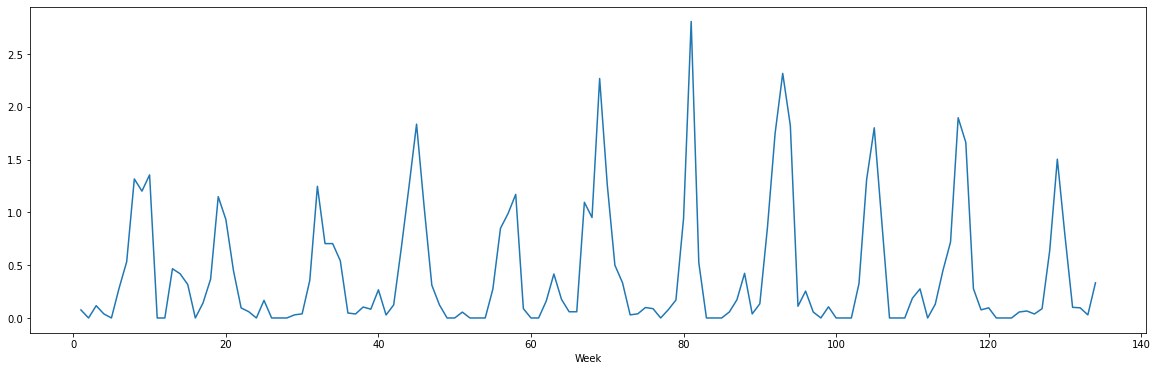

In [ ]:
pyplot.rcParams["figure.figsize"] = (20,6)
train_set.plot()

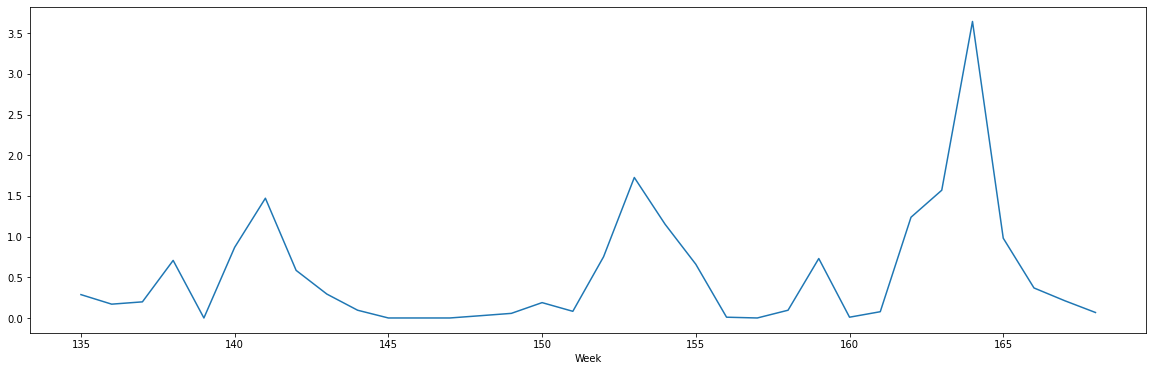

In [ ]:
test_set.plot()

Train the model

In [ ]:
start = len(train_set) + 1
end = len(data)

arima_model_fit = ARIMA(data, order = (2, 0, 1)).fit()  # the previously found order
arima_model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      4   No. Observations:                  168
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -113.123
Date:                Sat, 09 Jul 2022   AIC                            236.246
Time:                        05:12:48   BIC                            251.866
Sample:                             0   HQIC                           242.585
                                - 168                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4400      0.043     10.149      0.000       0.355       0.525
ar.L1          1.3866      0.117     11.866      0.000       1.158       1.616
ar.L2         -0.6455      0.074     -8.722      0.000      -0.791      -0.500
ma.L1         -0.8110      0.119     -6.787      0.000      -1.045      -0.577
sigma2         0.2238      0.015     15.193      0.000       0.195       0.253
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               346.52
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.96   Skew:                             1.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**4. Predict values on validation set**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


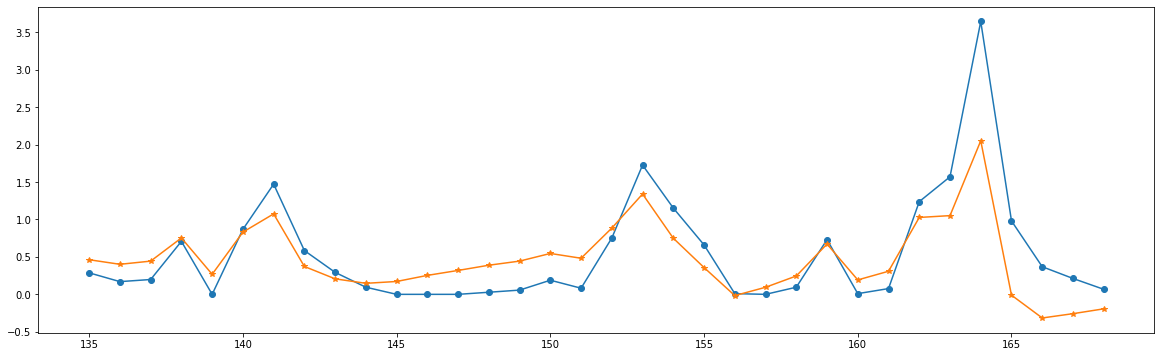

In [ ]:
start = len(train_set) + 1
end = len(data)
predictions = arima_model_fit.predict(start = start, end = end, typ='levels')
pyplot.plot(test_set, '-o', predictions, '-*')

In [ ]:
forecast = arima_model_fit.get_prediction(start = start, end = end, typ='levels')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [ ]:
forecast

In [ ]:
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

In [ ]:
yhat_conf_int

In [ ]:
yhat_lower = list(yhat_conf_int['lower 4'])

In [ ]:
type(yhat_lower)

list

In [ ]:
yhat_lower

In [ ]:
yhat_upper = list(yhat_conf_int['upper 4'])

In [ ]:
yhat_upper

In [ ]:
yhat_values = yhat.to_list()

In [ ]:
yhat_values

In [ ]:
index = list(range(0, yhat.size))

In [ ]:
index

In [ ]:
y = list(test_set)

In [ ]:
result = pd.DataFrame(list(zip(index, y, yhat_values, yhat_lower, yhat_upper)), columns =['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper'])

In [ ]:
result.set_index('ds')

In [ ]:
result['error'] = result['y'] - result['yhat']
result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']

In [ ]:
result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 0.5*x['uncertainty']) else 'No', axis = 1)

In [ ]:
fig = px.scatter(result, x='ds', y='y', color='anomaly', color_discrete_map={'Yes': 'red', 'No': 'black'}, title='Water consumption anomalies')

# Add traces
#fig.add_trace(go.Scatter(x=result['ds'], y=result['y'], mode='markers', name='yhat', fill ='anomaly'))
fig.add_trace(go.Scatter(x=result['ds'], y=result['yhat'], name='Predicted values', marker=dict(
            color='Orange',
            size=20,
            line=dict(
                color='MediumPurple',
                width=2
            )
        )))
fig.add_trace(go.Scatter(x=result['ds'], y=result['y'], name='Real values', marker=dict(
            color='Blue',
            size=20,
            line=dict(
                color='MediumPurple',
                width=2
            )
        )))

fig.update_layout(title="Water consumption anomalies", xaxis_title="Weeks", yaxis_title="Consumption")
fig.update_traces(marker={'size': 8})

fig.show()

In [ ]:
fig = px.scatter(result, x='ds', y='y', title='Values', color_discrete_sequence=['black'])

# Add traces
#fig.add_trace(go.Scatter(x=result['ds'], y=result['y'], mode='markers', name='yhat', fill ='anomaly'))
fig.add_trace(go.Scatter(x=result['ds'], y=result['yhat_lower'], name='Lower confidence', marker=dict(
            color='Red',
            size=20,
            line=dict(
                color='MediumPurple',
                width=2
            )
        )))
fig.add_trace(go.Scatter(x=result['ds'], y=result['yhat_upper'], name='Upper confidence', marker=dict(
            color='Blue',
            size=20,
            line=dict(
                color='MediumPurple',
                width=2
            )
        )))

fig.update_layout(title="Uncertainty level", xaxis_title="Weeks", yaxis_title="Consumption")
fig.update_traces(marker={'size': 8})

fig.show()

In [ ]:
fig = px.line(result.reset_index(), x='ds', y=['y','yhat'])
fig = px.scatter(result.reset_index(), x='ds', y='y', color='anomaly', title='Water consumption anomalies')

#slider
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
              dict(count=1, label='1y', step="year", stepmode="backward"),
              dict(count=2, label='3y', step="year", stepmode="backward"),
              dict(count=2, label='5y', step="year", stepmode="backward"),
              dict(step="all")
        ])
    )
)
fig.show()

**5. Calculate RMSE**

In [ ]:
rmse = sqrt(mean_squared_error(predictions, test_set))
print(rmse)

4.4806612876825165


Make predictions on future values

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


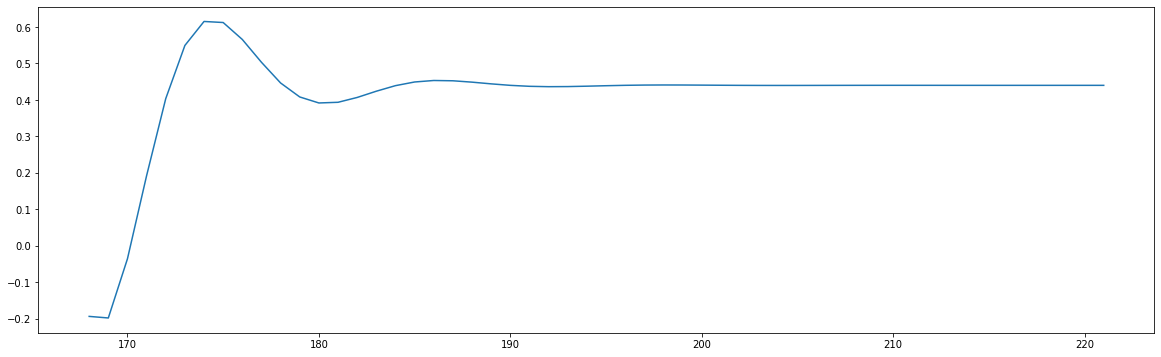

In [ ]:
predictions = arima_model_fit.predict(start = len(data), end = len(data) + 53, typ='levels').rename("Future one year predictions")
predictions.plot()

## Forecast on column function

Stationarity check

In [ ]:
def adfuller_test(data):
  test_result = adfuller(data)
  test_labels = ['ADF Statistics', 'p-value', 'Number of lags used', 'Number of observations used']
  for value, label in zip(test_result, test_labels):
    print(f'{label}: {value}')
  if test_result[1] <= 0.05:
    print('Stationary data')
  else: print('Non-stationary data')

AutoARIMA on column


In [ ]:
def arima_on_column(data, train_set_percentage = 0.8):
  # split into train and test sets
  train_set, test_set = split_into_train_and_test(data, train_set_percentage)

  # fit the ARIMA model
  arima_model_fit = auto_arima(data, start_p=0, max_p=4, start_q=0, max_q=4, start_P = 0, start_Q = 0, m = 24, test = 'adf', d = None, stepwise = True, trace=True).fit(train_set)

  # calculate predictions
  predictions = arima_model_fit.predict(n_periods = len(test_set), typ='levels')

  # show results
  pyplot.rcParams["figure.figsize"] = (25, 6)
  fig, ax = pyplot.subplots()
  ax.plot(range(len(train_set), len(data)), test_set, label = "Test data")
  ax.plot(range(len(train_set), len(data)), predictions, label = "Prediction")
  ax.legend()
  pyplot.show()

  mse = mean_squared_error(test_set, predictions)
  print(f'MSE: {mse}')
  print(f'RMSE: {sqrt(mse)}')

In [ ]:
def arima_on_column_with_anomaly_detection(data, column_index, train_set_percentage = 0.8):
  data = dataset.iloc[:, column_index]

  # split into train and test sets
  train_set, test_set = split_into_train_and_test(data, train_set_percentage)

  # find the ARIMA model
  auto_arima_model_fit = auto_arima(train_set, start_p=0, max_p=4, start_q=0, max_q=4, start_P = 0, start_Q = 0, m = 24, test = 'adf', d = None, stepwise = True, trace=True).fit(train_set)
  arima_order = auto_arima_model_fit.order
  arima_seasonal_order = auto_arima_model_fit.seasonal_order

  # fit the ARIMA model
  #arima_model_fit = ARIMA(train_set, order = arima_order).fit()
  arima_model_fit = sm.tsa.statespace.SARIMAX(train_set, order=arima_order, seasonal_order=arima_seasonal_order).fit()

  # calculate predictions
  forecast = arima_model_fit.get_prediction(n_periods = len(test_set), typ='levels')
  predictions = arima_model_fit.predict(n_periods = len(test_set), typ='levels')

  yhat = forecast.predicted_mean
  yhat_conf_int = forecast.conf_int(alpha=0.05)

  yhat_lower = list(yhat_conf_int[f'lower {column_index}'])
  yhat_upper = list(yhat_conf_int[f'upper {column_index}'])
  index = list(range(0, yhat.size))
  y = list(test_set)
  result = pd.DataFrame(list(zip(index, y, yhat_values, yhat_lower, yhat_upper)), columns =['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper'])
  result.set_index('ds')
  result['error'] = result['y'] - result['yhat']
  result['uncertainty'] = result['yhat_upper'] - result['yhat_lower']
  result['anomaly'] = result.apply(lambda x: 'Yes' if(np.abs(x['error']) > 0.5*x['uncertainty']) else 'No', axis = 1)

  fig = px.scatter(result, x='ds', y='y', color='anomaly', color_discrete_map={'Yes': 'red', 'No': 'black'}, title='Water consumption anomalies')

  fig.add_trace(go.Scatter(x=result['ds'], y=result['yhat'], name='Predicted values', marker=dict(
              color='Orange',
              size=20,
              line=dict(
                  color='MediumPurple',
                  width=2
              )
          )))
  fig.add_trace(go.Scatter(x=result['ds'], y=result['y'], name='Real values', marker=dict(
              color='Blue',
              size=20,
              line=dict(
                  color='MediumPurple',
                  width=2
              )
          )))

  fig.update_layout(title="Water consumption anomalies", xaxis_title="Weeks", yaxis_title="Consumption")
  fig.update_traces(marker={'size': 8})

  fig.show()

  mse = mean_squared_error(test_set, predictions)
  print(f'MSE: {mse}')
  print(f'RMSE: {sqrt(mse)}')

In [ ]:
# split into train and test sets
train_set, test_set = split_into_train_and_test(dataset.iloc[:, 5], 0.8)

# fit the ARIMA model
auto_arima_model_fit = auto_arima(train_set, start_p=0, max_p=4, start_q=0, max_q=4, start_P = 0, start_Q = 0, m = 24, test = 'adf', d = None, stepwise = True, trace=True).fit(train_set)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=206.719, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=152.001, Time=0.96 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=167.294, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=327.052, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=171.653, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=149.892, Time=6.38 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=6.56 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=146.723, Time=1.03 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=158.233, Time=0.24 sec
 ARIMA(1,0,0)(1,0,2)[24] intercept   : AIC=inf, Time=6.83 sec
 ARIMA(1,0,0)(0,0,2)[24] intercept   : AIC=155.293, Time=1.19 sec
 ARIMA(1,0,0)(2,0,2)[24] intercept   : AIC=150.487, Time=6.65 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=148.130, Time=1.63 sec
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=14

In [ ]:
auto_arima_model_fit

ARIMA(order=(1, 0, 0), scoring_args={}, seasonal_order=(1, 0, 1, 24),
      suppress_warnings=True)

In [ ]:
auto_arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  134
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 24)   Log Likelihood                 -68.361
Date:                              Sat, 09 Jul 2022   AIC                            146.723
Time:                                      06:45:45   BIC                            161.212
Sample:                                           0   HQIC                           152.611
                                              - 134                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0276      0.033      0.838      0.402      -0.037       0.092
ar.L1          0.4480      0.053      8.428      0.000       0.344       0.552
ar.S.L24       0.9189      0.096      9.609      0.000       0.731       1.106
ma.S.L24      -0.6911      0.206     -3.363      0.001      -1.094      -0.288
sigma2         0.1486      0.016      9.169      0.000       0.117       0.180
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               173.64
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             1.72
Prob(H) (two-sided):                  0.30   Kurtosis:                         7.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
arima_order = auto_arima_model_fit.order

In [ ]:
arima_seasonal_order = auto_arima_model_fit.seasonal_order

In [ ]:
arima_order

(1, 0, 0)

In [ ]:
arima_seasonal_order

(1, 0, 1, 24)

In [ ]:
auto_arima_model_fit.model

AttributeError: ignored

In [ ]:
arima_model_fit = sm.tsa.statespace.SARIMAX(train_set, order=arima_order, seasonal_order=arima_seasonal_order).fit()
#arima_model_fit = ARIMA(train_set, order = arima_order).fit()  # the previously found order
arima_model_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    5   No. Observations:                  134
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 24)   Log Likelihood                 -76.307
Date:                              Sat, 09 Jul 2022   AIC                            160.613
Time:                                      06:47:50   BIC                            172.205
Sample:                                           0   HQIC                           165.324
                                              - 134                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5986      0.057     10.437      0.000       0.486       0.711
ar.S.L24       0.9297      0.063     14.696      0.000       0.806       1.054
ma.S.L24      -0.6367      0.168     -3.780      0.000      -0.967      -0.307
sigma2         0.1602      0.016      9.775      0.000       0.128       0.192
===================================================================================
Ljung-Box (L1) (Q):                   3.02   Jarque-Bera (JB):                77.54
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             1.14
Prob(H) (two-sided):                  0.19   Kurtosis:                         5.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
forecast = arima_model_fit.get_prediction(n_periods = len(test_set), typ='levels')

In [ ]:
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

In [ ]:
yhat_conf_int

,lower 5,upper 5
Week,,
1,-1.251191,1.251191
2,-0.824504,1.180088
3,-0.860062,1.144530
4,-0.880257,1.124336
5,-0.910206,1.094386
...,...,...
130,-0.026350,1.545223
131,-0.166986,1.404587
132,0.700760,2.272332


### Forecast on 5th column

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=1255.602, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=998.302, Time=0.81 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=1075.306, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1417.006, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=1095.142, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=1049.935, Time=0.43 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=7.08 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=999.587, Time=0.97 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=999.476, Time=1.15 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=1006.574, Time=0.74 sec
 ARIMA(2,0,1)(1,0,0)[24] intercept   : AIC=1001.154, Time=1.33 sec
 ARIMA(1,0,0)(1,0,0)[24]             : AIC

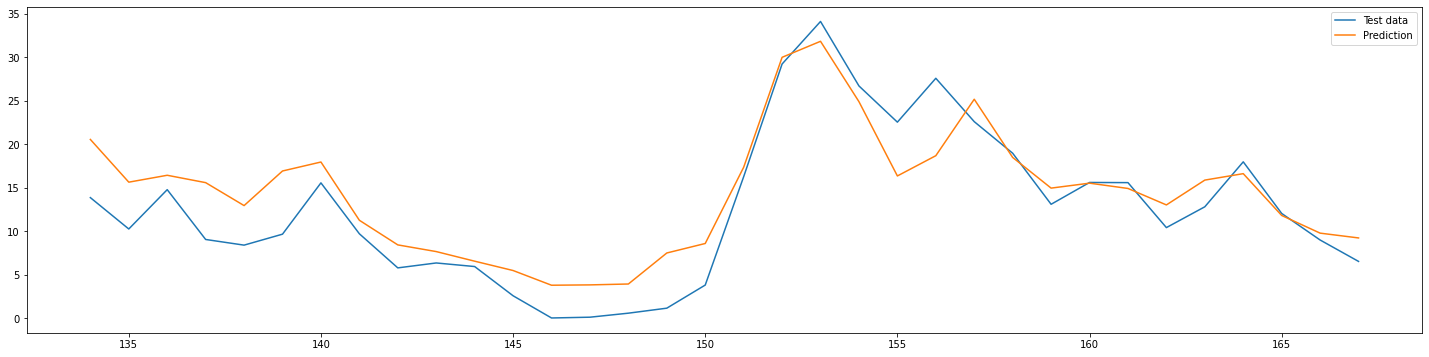

MSE: 14.248772801927341
RMSE: 3.7747546677800585


In [ ]:
arima_on_column(dataset.iloc[:, 5])

In [ ]:
arima_on_column_with_anomaly_detection(dataset, 5)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



### Forecast on 10th column

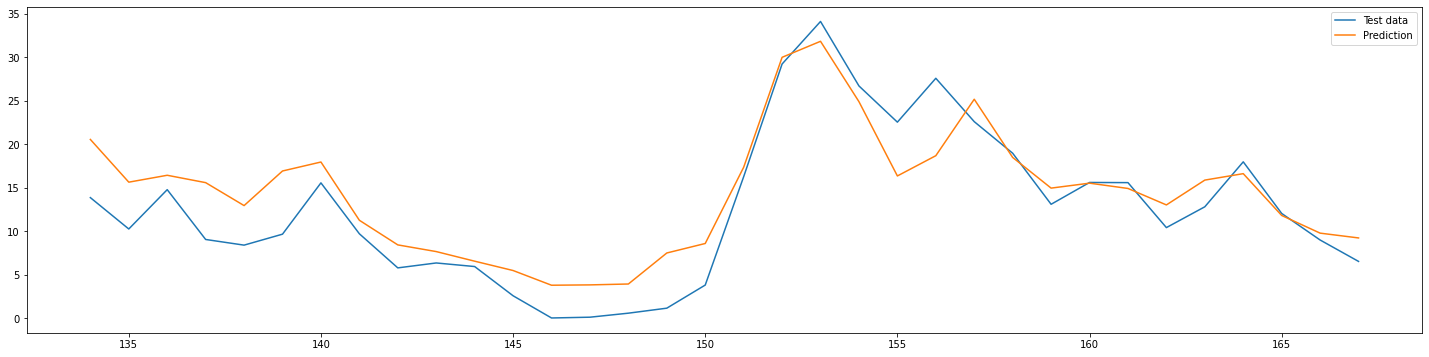

MSE: 14.248772801927341
RMSE: 3.7747546677800585


In [ ]:
arima_on_column(dataset.iloc[:, 10])

In [ ]:
arima_on_column_with_anomaly_detection(dataset, 10)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=1011.341, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=816.352, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=872.172, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1134.944, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=884.621, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=1.51 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=852.645, Time=0.37 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=799.404, Time=2.71 sec
 ARIMA(1,0,0)(2,0,2)[24] intercept   : AIC=inf, Time=7.04 sec
 ARIMA(1,0,0)(1,0,2)[24] intercept   : AIC=inf, Time=6.15 sec
 ARIMA(0,0,0)(2,0,1)[24] intercept   : AIC=830.849, Time=5.07 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=795.028, Time=7.28 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=1.98 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=inf, Tim

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



ValueError: ignored

### Forecast on 100th column

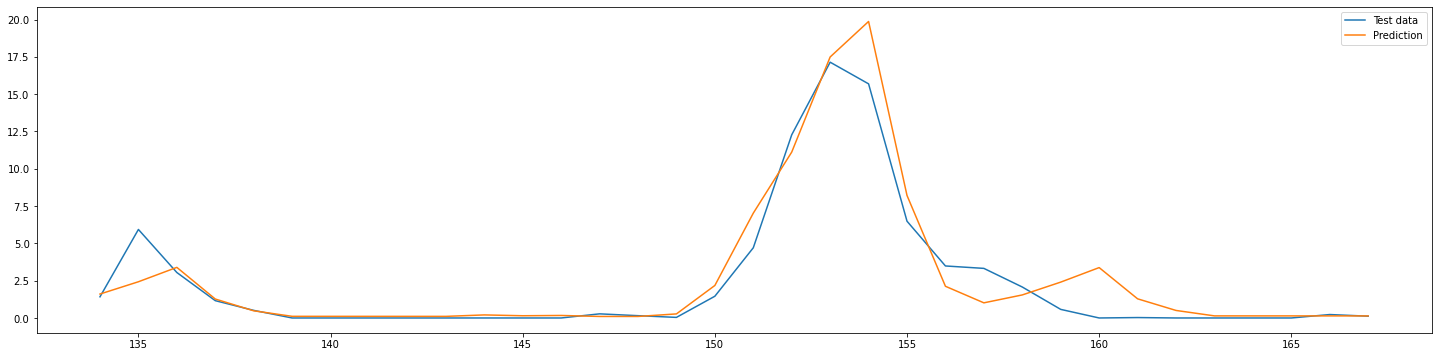

MSE: 1.9012586987769624
RMSE: 1.3788613776507639


In [ ]:
arima_on_column(dataset.iloc[:, 100])

In [ ]:
arima_on_column_with_anomaly_detection(dataset, 100)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



### Forecast on 125th column

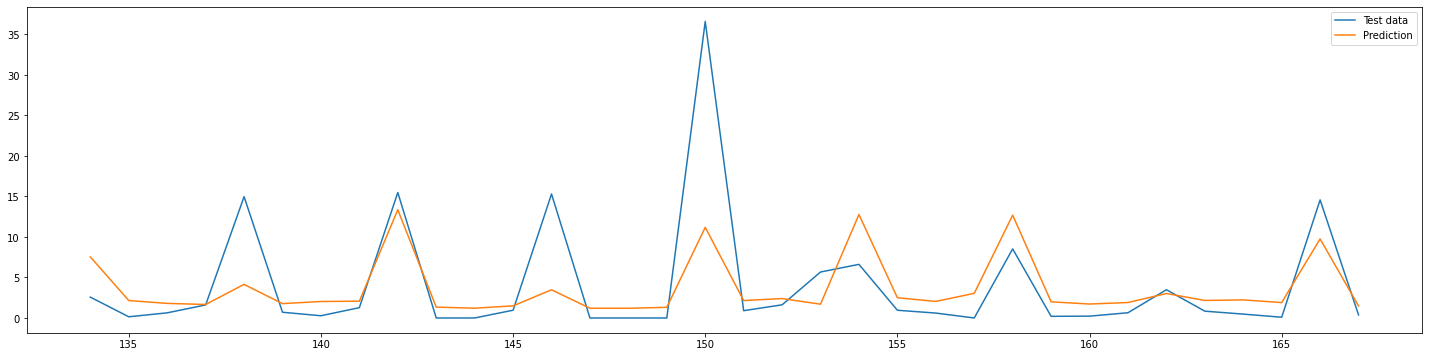

MSE: 31.692087159404277
RMSE: 5.629572555656804


In [ ]:
arima_on_column_with_anomaly_detection(dataset, 125)

### Forecast on 200th column

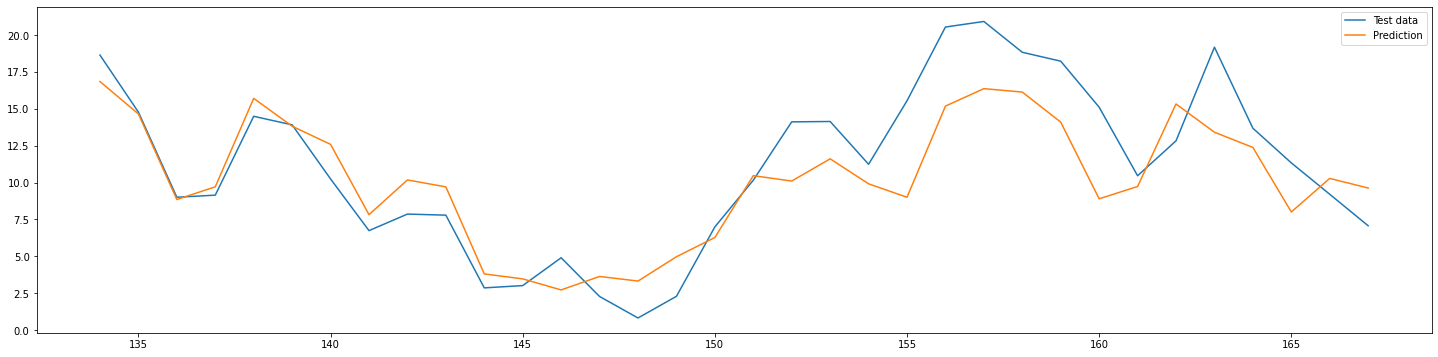

MSE: 8.30833578324666
RMSE: 2.8824183914287427


In [ ]:
arima_on_column_with_anomaly_detection(dataset, 200)

TOP columns for best results:

In [ ]:
def arima_result_on_column_for_best_results(data, train_set_percentage = 0.8):
  # split into train and test sets
  train_set, test_set = split_into_train_and_test(data, train_set_percentage)

  # fit the ARIMA model
  arima_model_fit = auto_arima(data, start_p=0, max_p=4, start_q=0, max_q=4, start_P = 0, start_Q = 0, test = 'adf', d = None, stepwise = True).fit(train_set)

  # calculate predictions
  predictions = arima_model_fit.predict(n_periods = len(test_set), typ='levels')

  mse = mean_squared_error(test_set, predictions)

  return mse

In [ ]:
def show_top_columns_for_best_results():
  results = []
  
  for i in range(0, 820):
    results.append([i, arima_result_on_column_for_best_results(dataset.iloc[:, i])])
  
  return results

results = show_top_columns_for_best_results()
print(results)

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.7/dist-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.7/dist-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.7/dist-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.7/dist-packages/pmdarima/arima/auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warn

[[0, 181.5457355212617], [1, 335.4310107798566], [2, 13.850324936422933], [3, 60.30151248264812], [4, 0.5650874505904098], [5, 0.0861566285150021], [6, 40.56743336166687], [7, 41.41407475685281], [8, 18.634054165338956], [9, 13.279946812988676], [10, 76.55112599537928], [11, 98.68410756172135], [12, 3.762581191465859], [13, 14.623687231637641], [14, 47.53491747202124], [15, 6.8995870818424905], [16, 57.31288427987438], [17, 18.589064397513738], [18, 201.67256905351678], [19, 3.6283163285561324], [20, 84.24558859860237], [21, 0.0], [22, 51.197266323989915], [23, 235.41950821995204], [24, 80.5816140137869], [25, 35.75849987968386], [26, 16.502583012847417], [27, 51.83074739727025], [28, 108.16075579138999], [29, 63.56316345057818], [30, 127.55520542666397], [31, 5.999406680854991], [32, 3.2996252337904814], [33, 48.83459880813129], [34, 121.55111583751076], [35, 64.84837100492605], [36, 5.780663527333178], [37, 2.2153507399111723], [38, 0.1286506670305337], [39, 62.875315838213616], [40,

In [ ]:
results.sort(key=lambda x: x[1])

In [ ]:
print(results)

[[21, 0.0], [76, 0.0], [122, 0.0], [215, 0.0], [221, 0.0], [293, 0.0], [305, 0.0], [308, 0.0], [317, 0.0], [427, 0.0], [508, 0.0], [624, 0.0], [758, 0.0], [810, 0.0], [729, 3.579976689188398e-22], [372, 3.1569256360168334e-08], [492, 1.0999506200568584e-05], [410, 3.11016792613252e-05], [304, 8.490796063712523e-05], [575, 0.0002078287243984668], [562, 0.0002417546743336085], [464, 0.00026253848235039523], [198, 0.0007435526628279688], [483, 0.0008438416230097716], [452, 0.0008643457339735895], [382, 0.0010538297904274761], [461, 0.0015532484011245532], [344, 0.0016006472830464508], [144, 0.004105131372947388], [787, 0.005125438548476773], [254, 0.005872539327004698], [56, 0.007259937652133444], [377, 0.012144479190352147], [150, 0.015524326143969307], [688, 0.018204194527002636], [42, 0.021842109711998077], [97, 0.023787534598403336], [282, 0.03706089846865887], [124, 0.04891299109194066], [60, 0.05725498921852417], [133, 0.06379065570486905], [462, 0.06479033380407356], [296, 0.065822

# Best results

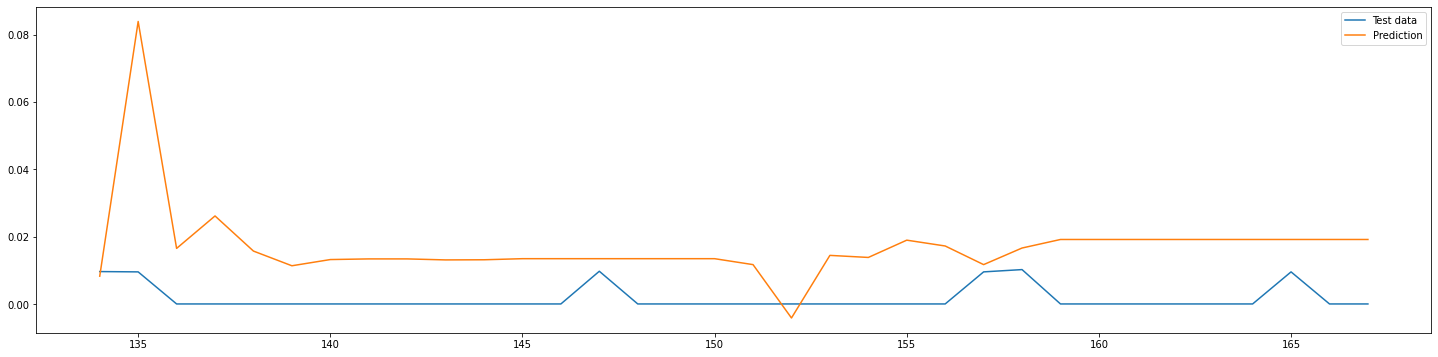

MSE: 0.00038039585672705383
RMSE: 0.019503739557506755


In [ ]:
arima_on_column(dataset.iloc[:, 464])

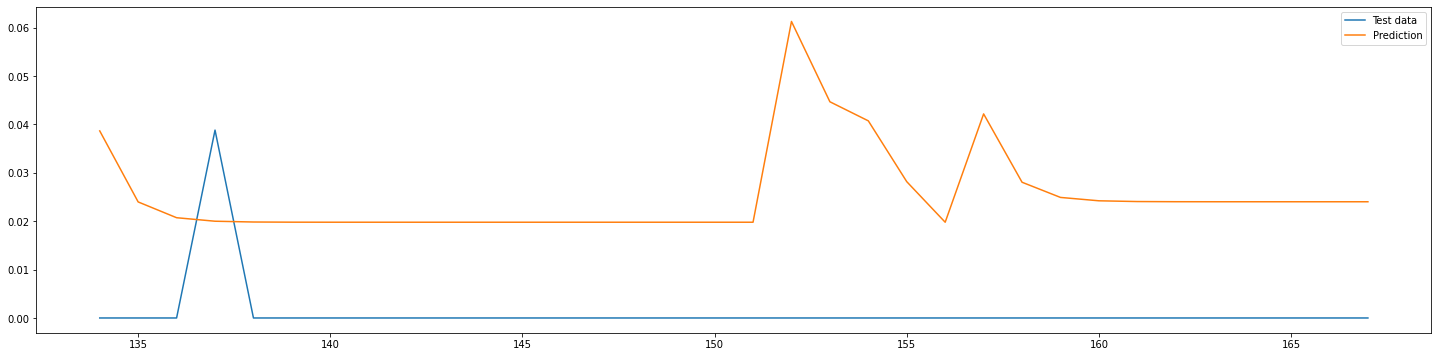

MSE: 0.0007282223902110611
RMSE: 0.02698559597657723


In [ ]:
arima_on_column(dataset.iloc[:, 198])

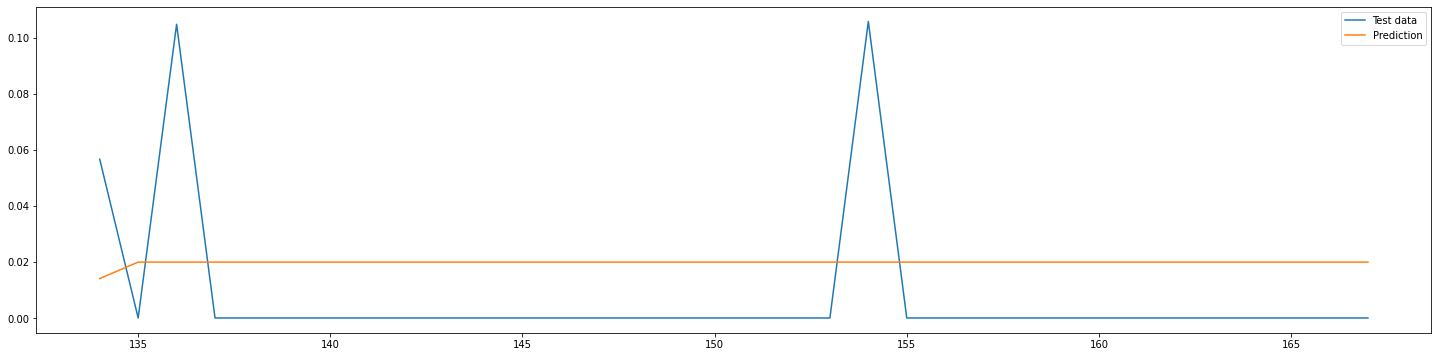

MSE: 0.0008438416230097716
RMSE: 0.02904895218436926


In [ ]:
arima_on_column(dataset.iloc[:, 483])

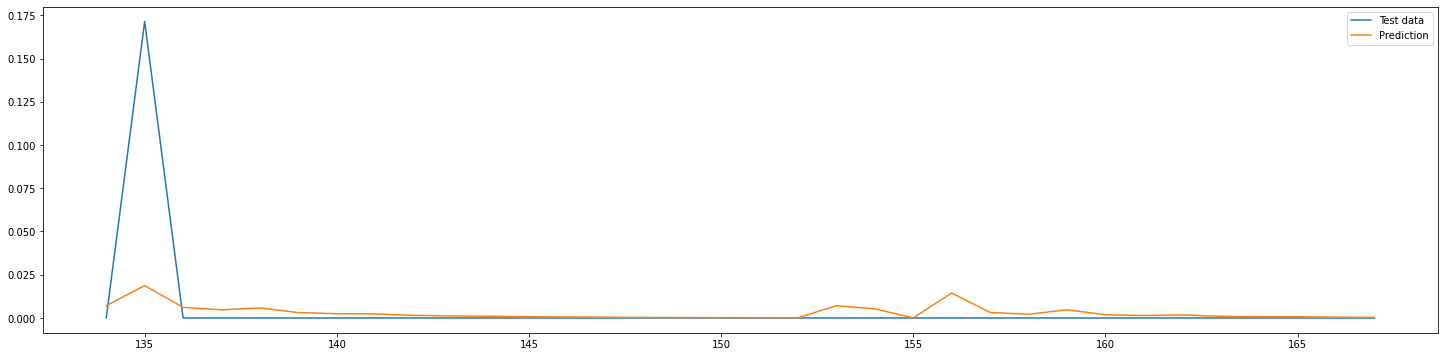

MSE: 0.0007008434662974358
RMSE: 0.026473448326529654


In [ ]:
arima_on_column(dataset.iloc[:, 452])

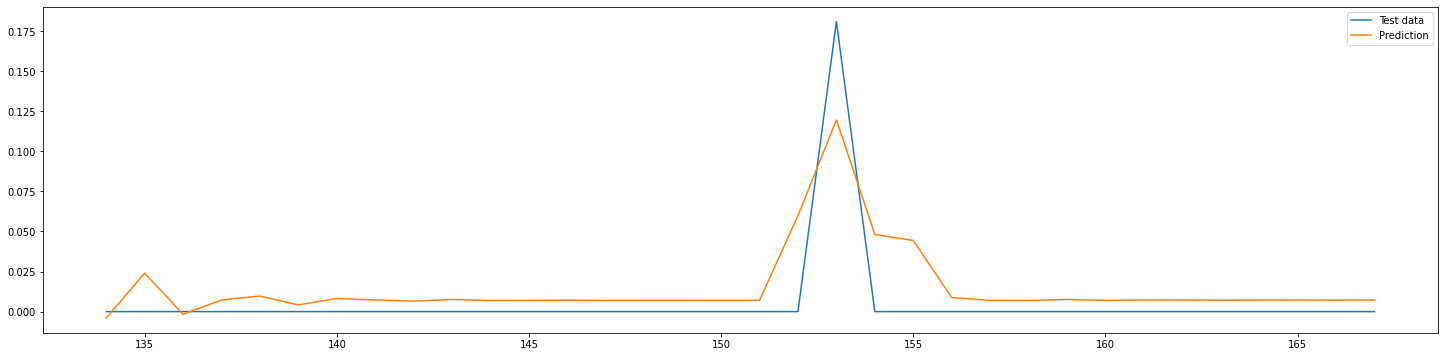

MSE: 0.0004014699215642937
RMSE: 0.020036714340537314


In [ ]:
arima_on_column(dataset.iloc[:, 382])